# Morris-Lecar Model

### model is described using two variables V and n.

## ${Cm}\frac{dV}{dt} = {I_{app}} - {g_{l}}({V} - {E_{l}}) -{g_{k}}{n}({V} - {E_{k}}) - {g_{Ca}}{m_{\infty}}({V} - {E_{Ca}})$


## $\frac{dn}{dt} = \frac{\phi({n_{\infty}(V)} - {n})} {\tau_{n}(V)}  $

## Where 
## $ {m_{\infty}(V)} = \frac{1}{2}(1 + {\tanh(\frac{V - V1}{V2})})  $
## $ {n_{\infty}(V)} = \frac{1}{2}(1 + {\tanh(\frac{V - V3}{V4})})  $
## $ {\tau_{n}(V)} = \frac{1}{\cosh(\frac{V - V3}{2V4})} $
### Here we are taking V as var1 and n as var2 in the code

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [72]:
def get_next_state(prev_state,model_params,dt):
# Each state is a pair (var1,var2) describing current value of DE variables
#      d (var1)/dt = f(var1, var2)
#      d (var2)/dt =  g(var1,var2)
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = model_params
    minf = 0.5*(1 + np.tanh((prev_state[0] - V1)/V2))
    ninf = 0.5*(1 + np.tanh((prev_state[0] - V3)/V4))
    ntau = 1/(np.cosh((prev_state[0] - V3)/(2*V4)))
    curr_state = np.zeros(2)
    curr_state[0] = prev_state[0] + dt*(I - gl*(prev_state[0] - el)- gk*prev_state[1]*(prev_state[0]-ek) - gca*minf*(prev_state[0] - eca))/cm
    curr_state[1] = prev_state[1] + dt*(phi*(ninf - prev_state[1])/ntau)
    return curr_state

In [73]:
# get all values of var2 for the given range of var1 when d (var1)/dt = 0
def get_var1_nullcline(model_params,var1_range):
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = model_params
    var1_nullcline = np.zeros(len(var1_range))
    for i in range(len(var1_range)):
        minf = 0.5*(1 + np.tanh((var1_range[i] - V1)/V2))
        var1_nullcline[i] = (I - gl*(var1_range[i] - el) - gca*minf*(var1_range[i] - eca))/(gk*(var1_range[i] - ek))
    return var1_nullcline

In [74]:
# get all values of var2 for the given range of var1 when d (var2)/dt = 0
def get_var2_nullcline(model_params,var1_range):
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = model_params
    var2_nullcline = np.zeros(len(var1_range))
    for i in range(len(var1_range)):
        var2_nullcline[i] = 0.5 * (1 + np.tanh((var1_range[i]-V3)/V4))
    return var2_nullcline

In [75]:
def find_freq(states):
    var1=states[:,0]
    freq=len(find_peaks(var1)[0])
    if freq>0:
        T = 2000
        tscale = T/freq
        fscale = 1/tscale
    else:
        fscale=0
    return fscale

In [76]:
def get_state(states,params,dt):
    for i in range(1,states.shape[0]):
        states[i,:] = get_next_state(states[i-1,:],params,dt)
    return states

In [89]:
def get_state_I_f(states,params,dt,start_current,end_current):
    state_I = []
    state_f = []
    for current in range(start_current,end_current):
        params[-1]=current
        states = get_state(states,params,dt)
        state_I.append(current)
        freq=find_freq(states)
        state_f.append(freq)
    return state_I,state_f,states

In [103]:
def plot_nullclines_states(states,range1,range2,param,tstop,dt):
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = param
        # Create a figure with two pairs of axes for phase plot and time plot
    fig = plt.figure(figsize = [16,8])
    fig.suptitle(f'Morris-Lecar Neuron Model with phi={phi}, gca= {gca}, V3={V3}, V4={V4}, eca={eca}, ek= {ek}, el={el}, gk={gk}, gl= {gl}, V1= {V1}, V2={V2}, Cm ={cm}, I ={I}',fontsize=20)
    phax = fig.add_axes([.075,.1,.4,.8])
    timax = fig.add_axes([.55,.1,.4,.8])
    # Display nullcline and trajectory of neuron in phase space
    phax.plot(range1,get_var1_nullcline(param,range1),color='darkorange',linewidth=3,label='V-nullcline')
    phax.plot(range1,get_var2_nullcline(param,range1),color='darkgreen',linewidth=3,label='n-nullcline')
    phax.plot(states[:,0],states[:,1],color='slateblue',linewidth=3,label='neuron trajectory')

    # Display trajectory of var1 and var2 with time
    timax.plot(np.arange(0,tstop,dt),states[:,0],color='slateblue',linewidth=3,label='V')
    timax.plot(np.arange(0,tstop,dt),states[:,1],color='maroon',linewidth=3,label='n')
    # Set legends and other graph parameters
    phax.set_xlabel('V')
    phax.set_ylabel('n')
    timax.set_xlabel('Time')
    timax.set_ylabel('V/n')
    phax.set_xlim(min(range1),max(range1))
    phax.set_ylim(min(range2),max(range2))
    phax.legend(loc=0)
    timax.legend(loc=0)
    plt.show()

In [111]:
def plot_freq_I(state_I,state_f):    
    fig2 = plt.figure(figsize=(12,8))
    fiax = fig2.add_subplot(111)
    fiax.plot(state_I,state_f,color='maroon',linewidth=3)
    fiax.set_xlabel('I')
    fiax.set_ylabel('f')
    fiax.set_title('Frequency vs Current')
    plt.show()    

In [112]:
tstop = 2000 # time to simulate
dt = .1 #ms discrete time step
range1 = np.arange(-65,50,1)
range2 = np.arange(-.1,.6,.01)
states = np.zeros((int(tstop/dt),2)) 

In [113]:
#Hopf Type-2
#phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I
params_hopf = [0.04,4.4,2,30,120,-84,-60,8,2,-1.2,18,20,90] #Hopf
params_snlc = [0.067,4,12,17.4,120,-84,-60,8,2,-1.2,18,20,40] #SNLC
params_homoclinic = [0.23,4,12,17.4,120,-84,-60,8,2,-1.2,18,20,40] #Homoclinic

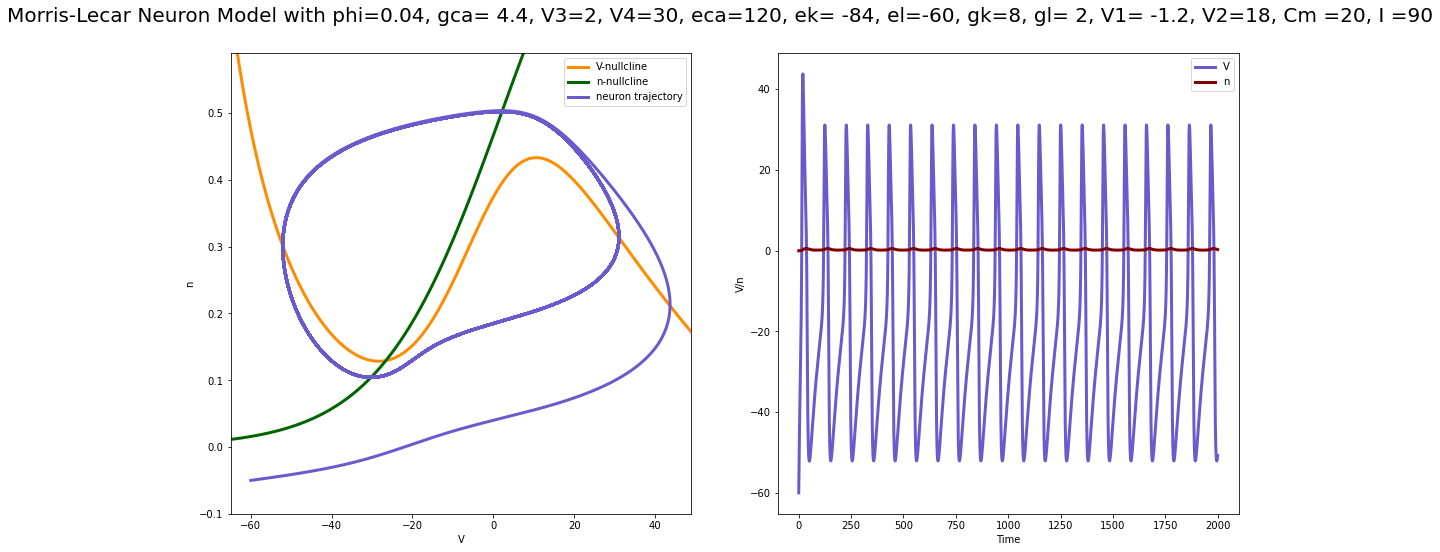

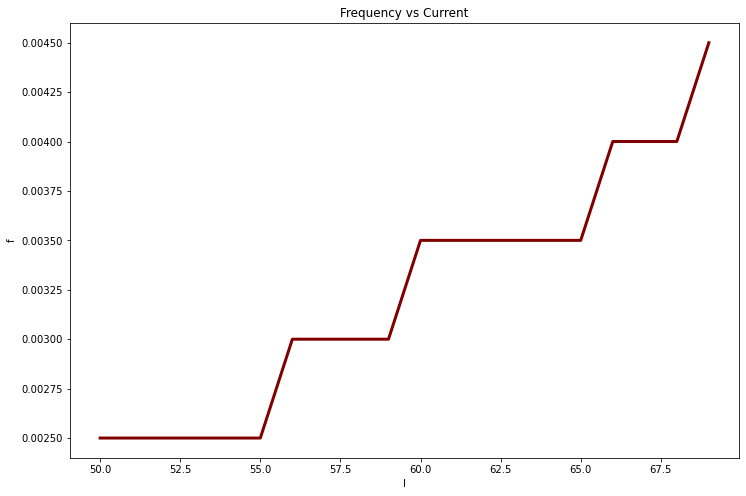

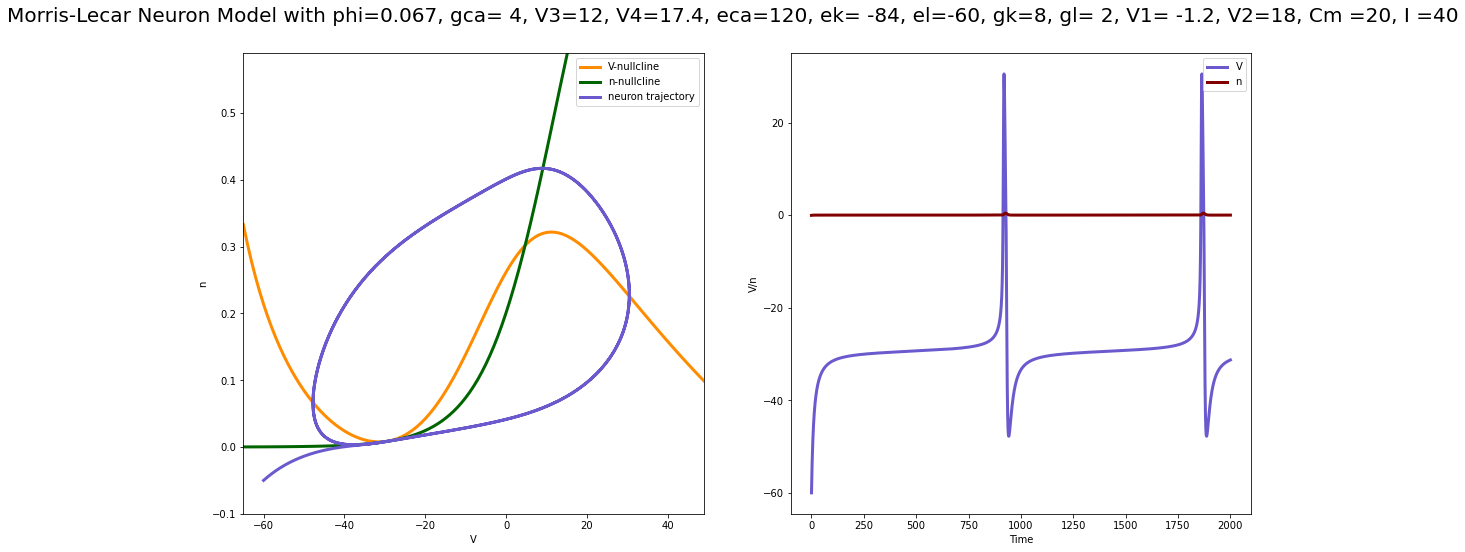

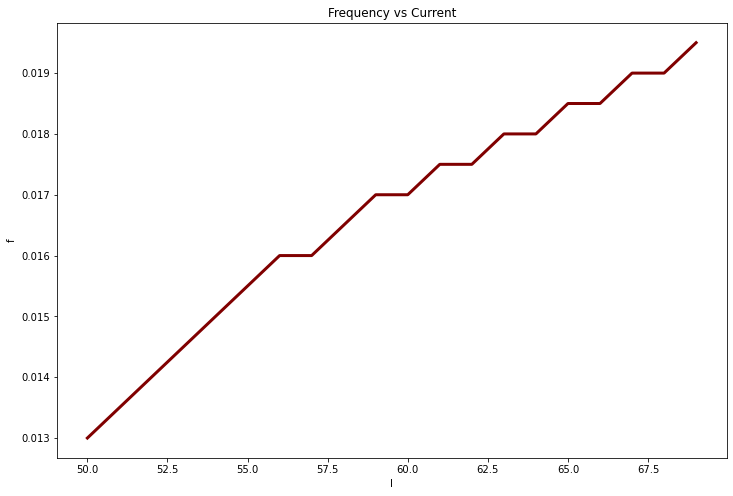

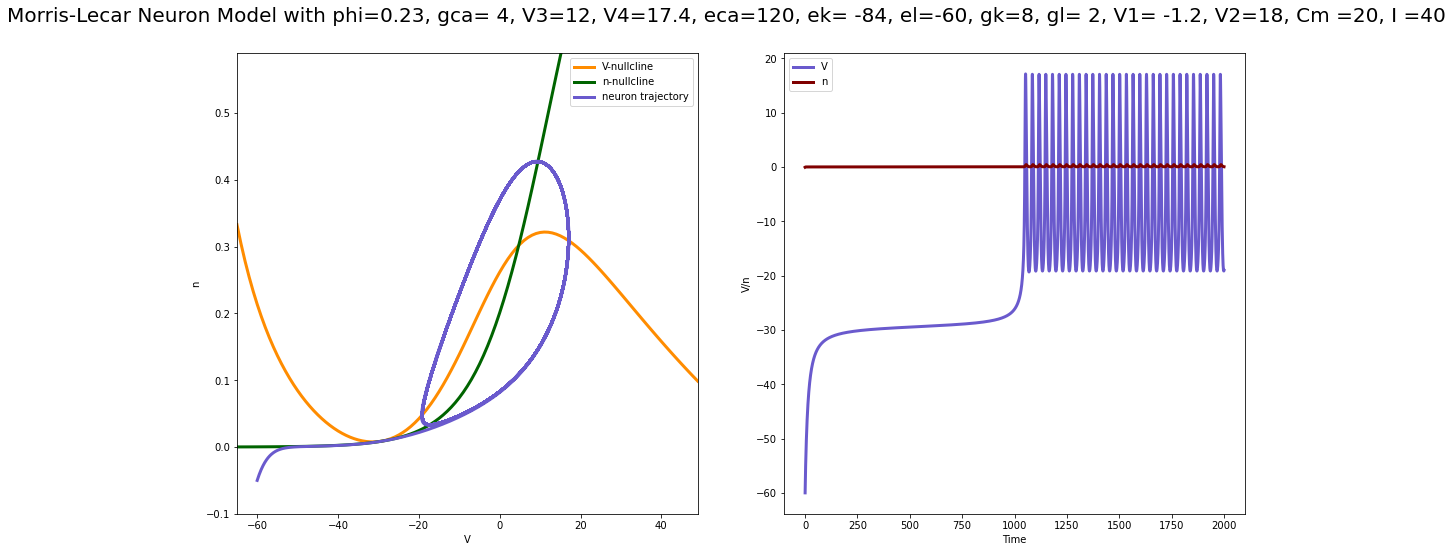

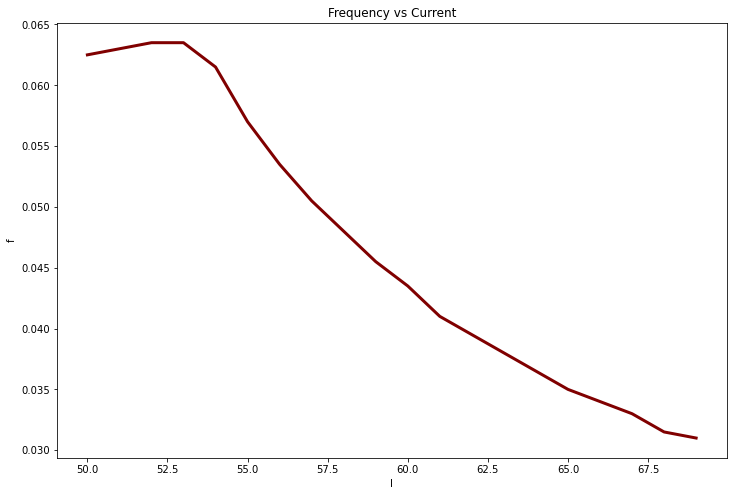

In [114]:
for params in [params_hopf,params_snlc,params_homoclinic]:
    state_I = []
    state_f = []
    states[0] = [-60,-0.05]
    states = get_state(states,params,dt)
    plot_nullclines_states(states,range1,range2,params,tstop,dt)
    state_I,state_f,states = get_state_I_f(states,params.copy(),dt,50,70)
    plot_freq_I(state_I,state_f)